# Прогнозирование уровня средней заработной платы в России

**`Внимание:`** В данном ноутбуке анализ проведён на данных по 08.2021. Данные взяты из источника, ссылка на которой есть в задании: [WAG_M.htm](http://sophist.hse.ru/hse/1/tables/WAG_M.htm)

К сожалению не удалось загрузить csv файл с подготовленными данными в том же формате, поэтому, если захотите проверить, придётся это делать исходя из данных по ссылке (данные от начала и до 01.07.2016 полностью совпадают с данными, приложенными в задании).

Зато в конце вас ждёт удивительное открытие о том какая средняя ЗП ждёт россиян в будущем 😉

In [30]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

%matplotlib inline

### Загрузка данных

In [2]:
df = pd.read_csv('WAG_C_M_08-2021.csv', sep=';', index_col='month', parse_dates=['month'], dayfirst=True)
df.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### Посмотрим на график ряда

<AxesSubplot:xlabel='month'>

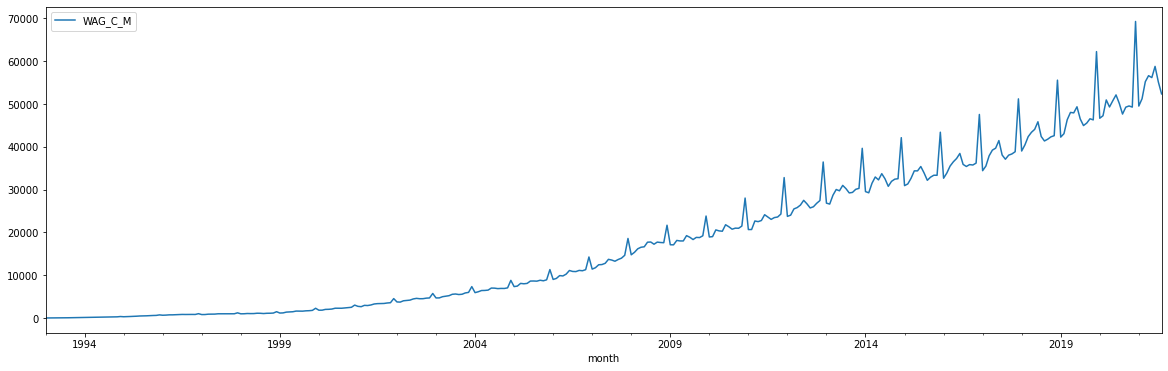

In [3]:
df.plot(figsize=(20,6))

Наблюдается:
* явно выраженная сезонность
* Возрастающий трэнд
* Очевидна нестационарность дисперсии. Чем дальше во времени, тем больше дисперсия

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=1.000000


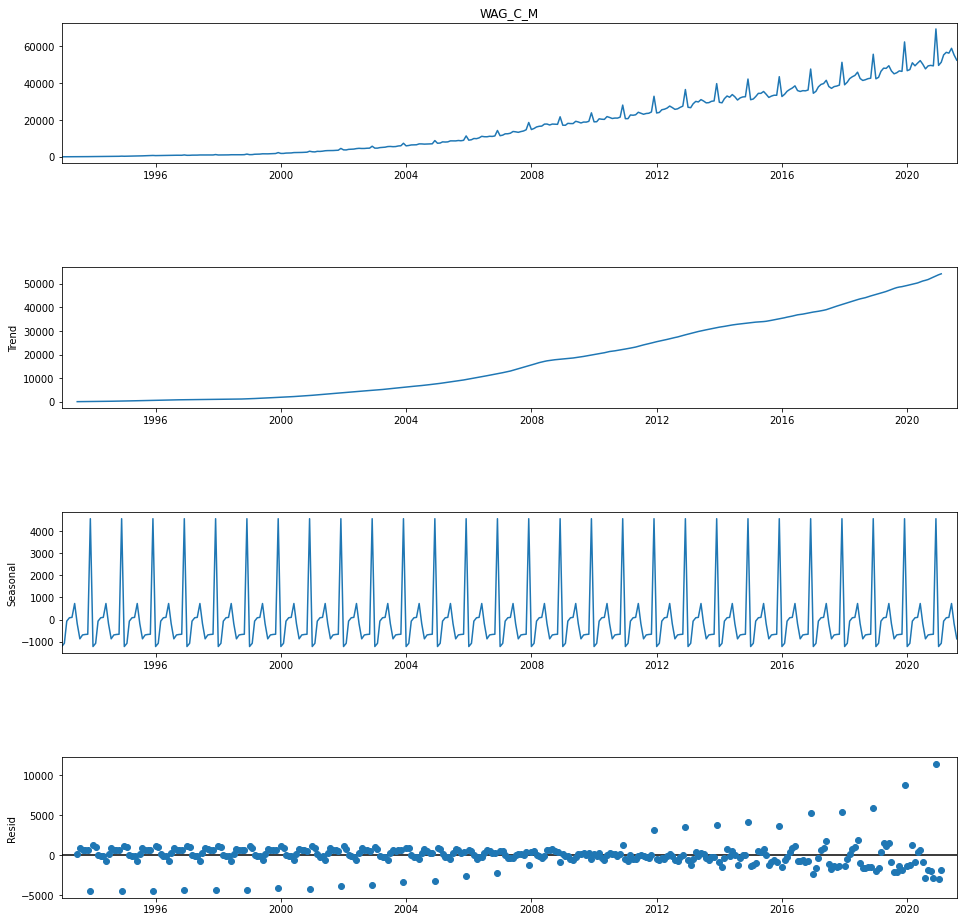

In [4]:
fig = sm.tsa.seasonal_decompose(df.WAG_C_M).plot()
fig.set_figheight(15)
fig.set_figwidth(15)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[1])

* Данные нестационарны с максимальным p-value критерия Дики-Фуллера
* Трэнд практически монотонно неубывающий
* Подтвержадется хорошо выраженная сезонность
* Остатки не похожи на белый шум

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.296896
Критерий Дики-Фуллера: p=0.728115


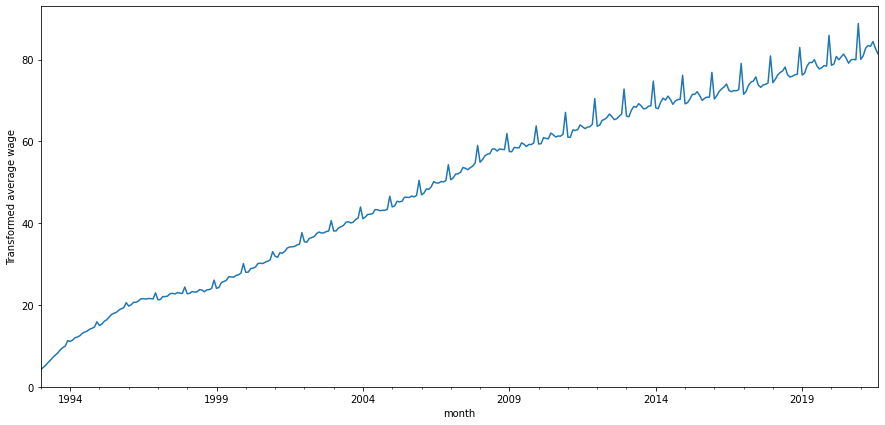

In [5]:
df['wage_box'], lmbda = stats.boxcox(df.WAG_C_M)
plt.figure(figsize=(15,7))
df.wage_box.plot()
plt.ylabel(u'Transformed average wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wage_box)[1])

Ряд всё ещё очень далёк от стационраности. Это явно видно визуально, да и p-value критерия Дики-Фуллера слишком высокий

___
### Дифференцирование ряда

Критерий Дики-Фуллера: p=0.104905


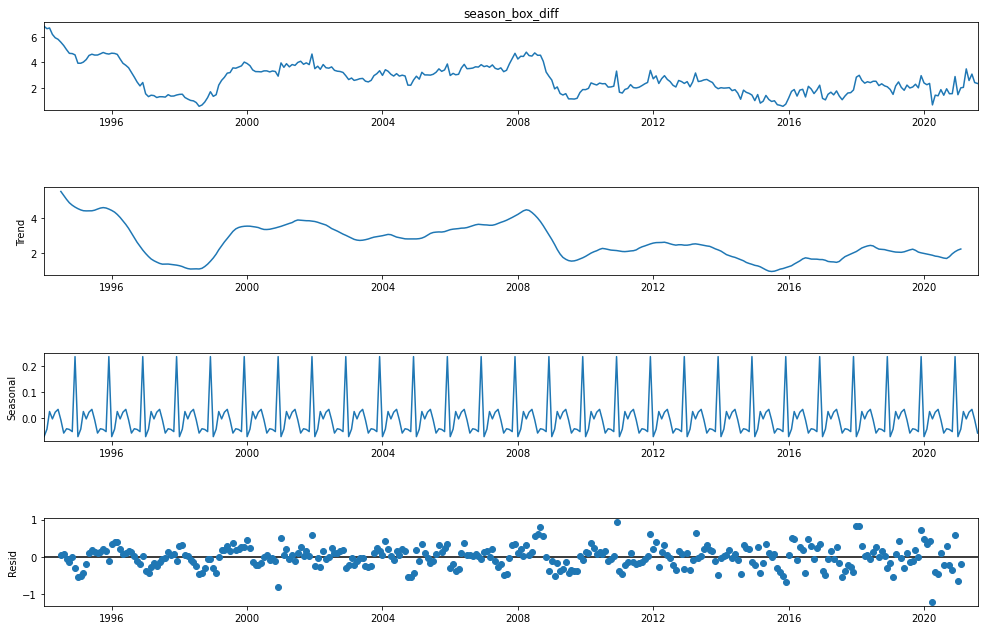

In [6]:
# Начнём с сезонного дифференцирования
df['season_box_diff'] = df.wage_box - df.wage_box.shift(12)
fig = sm.tsa.seasonal_decompose(df.season_box_diff[12:]).plot()
fig.set_figheight(10)
fig.set_figwidth(15)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.season_box_diff[12:])[1])

* Трэнд перстал быть мнотонным, но при этом он и не стабилен. Уровень ряда по прежнему не стационарен
* В остатках уже не очевидны временные зависимости. Они стали больше похожи на белый шум
* Критерий Дики-Фуллера уже намного лучше, но отвергнуть гипотезу о нестационарности на уровне 0.05 мы по прежнему не можем

Выполним второе дифференцирование на одну временную метку

Критерий Дики-Фуллера: p=0.003525


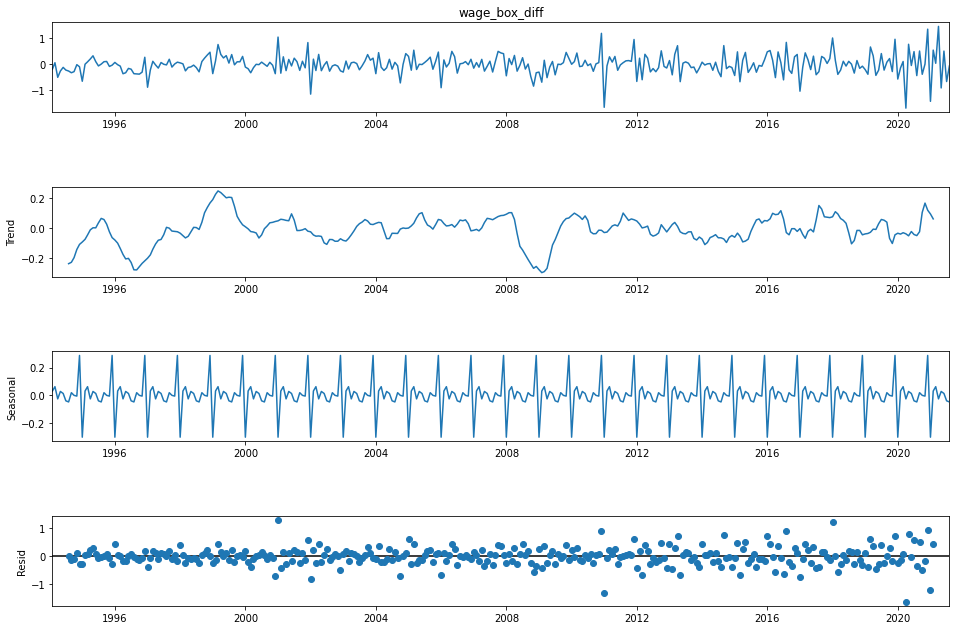

In [7]:
df['wage_box_diff'] = df.season_box_diff - df.season_box_diff.shift(1)
fig = sm.tsa.seasonal_decompose(df.wage_box_diff[13:]).plot()
fig.set_figheight(10)
fig.set_figwidth(15)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.wage_box_diff[13:])[1])

* Намного лучше. Гипотеза о нестационарности ряда уверено отвергается критерием Дикки-Фуллера на уровне значимости 0.05
* В трэнде нет явно выраженных закономерностей
* Остатки похожи на белый шум. Они как минимум не смещенные, явных зависимостей во времени не наблюдается, но видно, что в правой части немного возрастает дисперсия остатков

___
### Подбор модели

Посмотрим на ACF и PACF полученного ряда:

[]

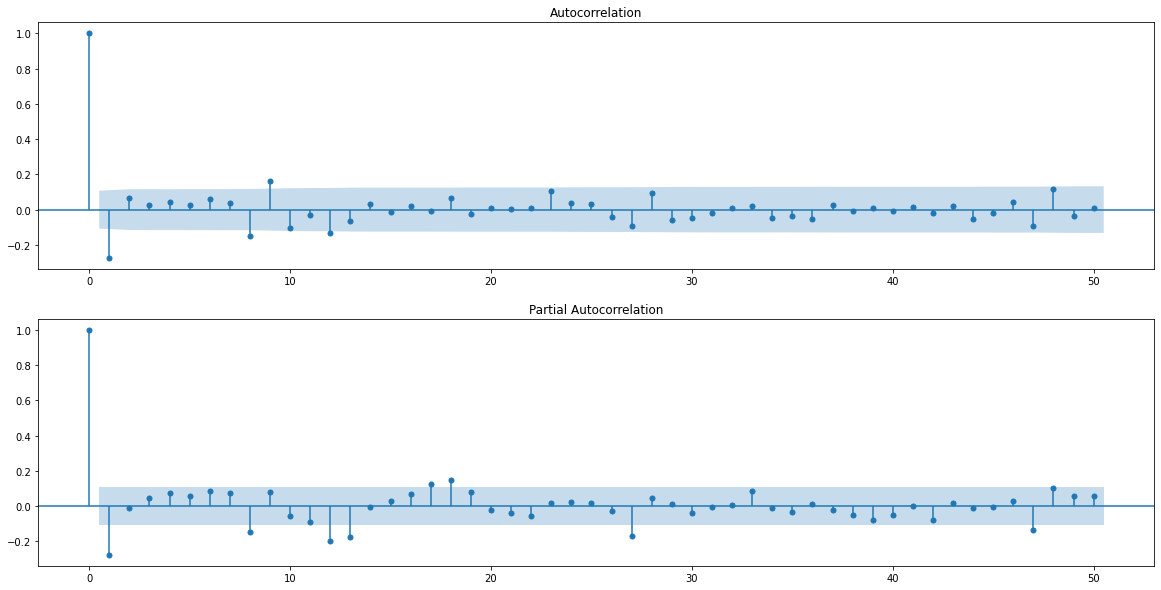

In [8]:
plt.figure(figsize=(20,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.wage_box_diff[13:].values.squeeze(), lags=50, ax=ax)
ax.plot()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.wage_box_diff[13:].values.squeeze(), lags=50, ax=ax)
ax.plot()

#### Подбор гиперпараметров (начальное приближение)

* $\textbf Q=1~~~$: на графике видна статистически значимая автокорреляция в точке `t=12`
* $\textbf q=9~~~$: с учётом выбранного Q, не следует брать q больше периода сезонности. В точке t=1 автокорреляция более выражена, но для начального приближения лучше взять значение соответствующее последней подходящей значимой автокорреляции в точке `t=9`
* $\textbf P=1~~~$: на графике видна значимая частичная автокорреляция в точке `t=12`
* $\textbf p=8~~~$: с учётом выбранного P, не следует брать p больше периода сезонности. В точке t=1 частичная автокорреляция более выражена, но для начального приближения лучше взять значение соответствующее последней подходящей значимой частичной автокорреляции в точке `t=8`

In [9]:
Qs = range(0, 2)
qs = range(0, 10)
Ps = range(0, 2)
ps = range(0, 9)
d=1
D=1

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

360

#### Подбор модели

In [11]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except Exception as e:
        print('wrong parameters:', param)
        print('error:', str(e))
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (4, 2, 1, 0)
error: LU decomposition error.
Wall time: 15min 1s


In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
111  (2, 7, 1, 1)  252.363821
338  (8, 4, 1, 1)  252.463622
346  (8, 6, 1, 1)  252.971867
342  (8, 5, 1, 1)  253.339457
110  (2, 7, 1, 0)  253.525809


Лучшая модель:

In [13]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             wage_box   No. Observations:                  344
Model:             SARIMAX(2, 1, 7)x(1, 1, [1], 12)   Log Likelihood                -114.182
Date:                              Tue, 30 Nov 2021   AIC                            252.364
Time:                                      19:06:35   BIC                            297.989
Sample:                                  01-01-1993   HQIC                           270.561
                                       - 08-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1781      0.082    -14.401      0.000      -1.338      -1.018
ar.L2         -0.80

**Вывод результатов модели не помещается полностью в ячейку. Поэтому дублирую полный отчёт ниже**

```shell
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             wage_box   No. Observations:                  344
Model:             SARIMAX(2, 1, 7)x(1, 1, [1], 12)   Log Likelihood                -114.182
Date:                              Tue, 30 Nov 2021   AIC                            252.364
Time:                                      19:06:35   BIC                            297.989
Sample:                                  01-01-1993   HQIC                           270.561
                                       - 08-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1781      0.082    -14.401      0.000      -1.338      -1.018
ar.L2         -0.8017      0.078    -10.307      0.000      -0.954      -0.649
ma.L1          0.8270      0.097      8.555      0.000       0.638       1.017
ma.L2          0.4455      0.092      4.848      0.000       0.265       0.626
ma.L3         -0.1640      0.069     -2.393      0.017      -0.298      -0.030
ma.L4          0.1789      0.080      2.228      0.026       0.022       0.336
ma.L5          0.2171      0.075      2.881      0.004       0.069       0.365
ma.L6          0.3182      0.068      4.704      0.000       0.186       0.451
ma.L7          0.2640      0.057      4.622      0.000       0.152       0.376
ar.S.L12      -0.6186      0.106     -5.853      0.000      -0.826      -0.411
ma.S.L12       0.3334      0.119      2.803      0.005       0.100       0.566
sigma2         0.1156      0.006     17.965      0.000       0.103       0.128
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               109.59
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.28   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
```

___
### Анализ остатков

Критерий Стьюдента: p=0.681076
Критерий Дики-Фуллера: p=0.000000


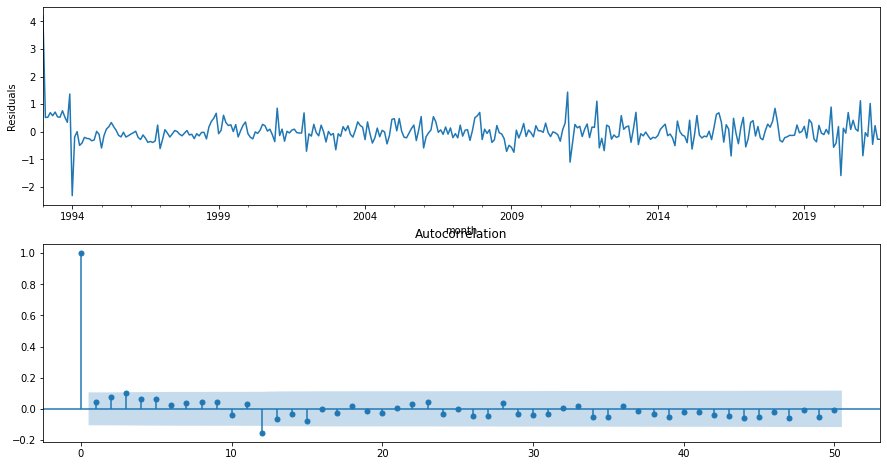

In [18]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=50, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

* Остатки несмещены (подтверждается критерием Стьюдента)
* Стационарны (подтверждается критерием Дики-Фуллера и визуально)
* Неавтокоррелированы. На коррелограме видны пара значимых лагов. Такой эффект можно объяснить случайностью при множественной проверке гипотез. Отсутсвие автокоррелированности остатков также подтверждается критерием Льюнга-Бокса. p-value = 0.94, что с большой уверенностью говорит о том, что мы не можем отвергнуть нулевую гипотезу об отсутсвии автокорреляции остатков

Посмотрим, насколько хорошо модель описывает данные:

Text(0, 0.5, 'average wage')

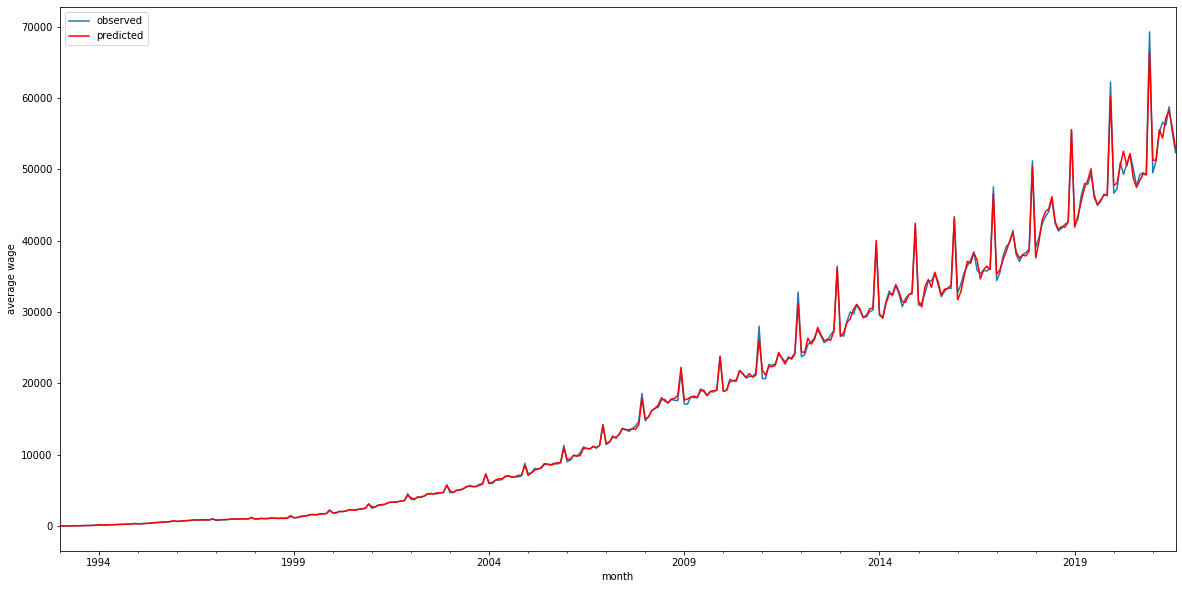

In [35]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(20,10))
df.WAG_C_M.plot(label='observed')
df.model.plot(color='r', label='predicted')
plt.legend()
plt.ylabel('average wage')

Предсказанный ряд хорошо аппроксимирует исходный

___
### Прогноз

Text(0, 0.5, 'average wage')

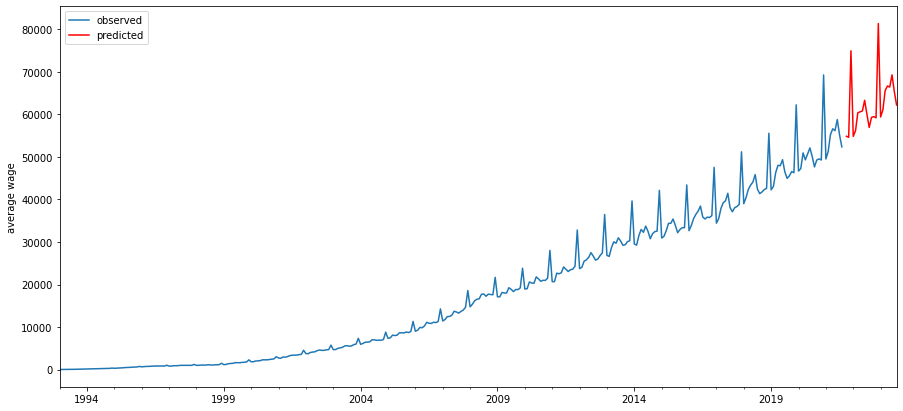

In [37]:
df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2021-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=345, end=368), lmbda)

plt.figure(figsize=(15,7))
df2.WAG_C_M.plot(label='observed')
df2.forecast.plot(color='r', label='predicted')
plt.legend()
plt.ylabel('average wage')

Визуально прогноз выглядит очень даже адекватно. Хорошо предсказывается сезонность и тренд.

In [57]:
df2[-24:][['forecast']].sort_values('forecast', ascending=False).iloc[0]

forecast    81352.096964
Name: 2022-12-01 00:00:00, dtype: float64

Таким образом ожидаем в декабре 2022 года среднюю ЗП россиян размером 81352 руб. 😁